In [1]:
import sys
import os

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), '..'))

from attacks import SalemAttack, EntropyAttack, ThresholdAttack
from utils.dataset_utils import get_subsampled_dataset, get_train_val_split, create_permuted_dataset, \
    get_inverse_normalization, get_normalization
from utils.validation import evaluate
from datasets import StanfordDogs, AFHQ, FakeCIFAR10
from torch.utils.data import TensorDataset, Subset
import torchvision
from models.cifar10_models import *
import torchvision.transforms as T

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
def get_cleaned_dataframe(csv_file_path, is_cifar10, rows_to_keep=None):
    # read the csv file
    df = pd.read_csv(csv_file_path)
    # get only the relevant columns
    df = df[['Unnamed: 0', 'Entropy Attack FPR', 'Threshold Attack FPR', 'Salem Attack FPR']]
    # rename the columns
    df.rename(columns={'Unnamed: 0': 'Dataset','Threshold Attack FPR': 'Max. Score', 'Salem Attack FPR': 'Top-3 Scores', 'Entropy Attack FPR': 'Entropy'}, inplace=True)

    if is_cifar10:
        df['Dataset'] = df['Dataset'].str.replace('CIFAR100', 'CIFAR-100').str.replace('Original', 'CIFAR-10')
    else:
        df['Dataset'] = df['Dataset'].str.replace('Original', 'Stanford Dogs').str.replace('-', ' ')

    df.index = df['Dataset'].values.tolist()

    if rows_to_keep is not None:
        df = df[df['Dataset'].isin(rows_to_keep)]
        df = df.reindex(rows_to_keep)

    return df


def plot_dataframe(df1, figsize=(7, 5.7), show_legend=False, show_y_label=False, show_y_axis=False):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(
        x=df1['Dataset'],
        y=df1['FPR'],
        hue=df1['Attack'],
        alpha=1,
        palette=sns.color_palette("tab10")
    )
    ax.tick_params(axis='x', labelrotation=60, labelsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.tick_params(axis='y', labelsize=20)

    if not show_y_label:
        ax.set(ylabel=None)

    ax.xaxis.label.set_size(25) 
    ax.yaxis.label.set_size(25)
    ax.xaxis.label.set_weight('bold')
    ax.yaxis.label.set_weight('bold')

    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('bold')

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('bold')

    ax.set_ylim([0, 1])
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.2))
    ax.grid(True)

    if not show_y_axis:
        for tick in ax.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)


    if not show_legend:
        ax.legend([], [], frameon=False)
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[-3:], labels=labels[-3:], prop={'weight':'bold', 'size':23}, frameon=True, labelspacing=0.05, borderpad=0.2, borderaxespad=0.0, framealpha=1, handletextpad=0.2)

    # remove the unnecessary x label
    plt.xlabel("")

    plt.tight_layout()

    return ax

In [3]:
rows_to_keep_cifar = ['CIFAR-10', 'Fake CIFAR-10', 'AFHQ Cats', 'STL-10', 'CIFAR-100', 'SVHN', 'Permuted', 'Scaled']
rows_to_keep_dogs = ['Stanford Dogs', 'Fake Dogs', 'AFHQ Dogs', 'AFHQ Cats', 'Permuted', 'Scaled']


# Salem CNN Relu

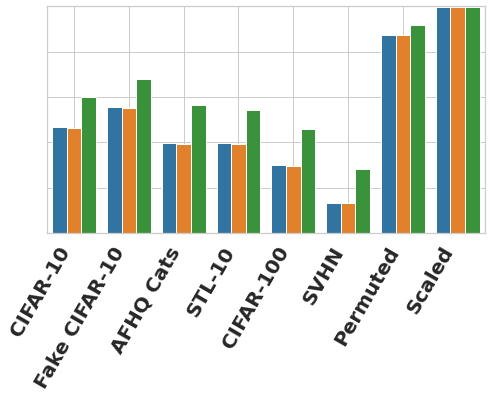

In [4]:
salem_cnn_relu_uncalibrated_df = get_cleaned_dataframe(
    '../results/salem_cnn_relu_cifar10_attack_results.csv',
    is_cifar10=True,
    rows_to_keep=rows_to_keep_cifar
)
salem_cnn_relu_uncalibrated_df = pd.melt(salem_cnn_relu_uncalibrated_df, id_vars=['Dataset'], var_name='Attack', value_name='FPR')
ax = plot_dataframe(salem_cnn_relu_uncalibrated_df, show_y_label=False, show_y_axis=False, show_legend=False)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('salem_cnn_relu_cifar10_attack_results_scores.pdf')


# Efficient Net

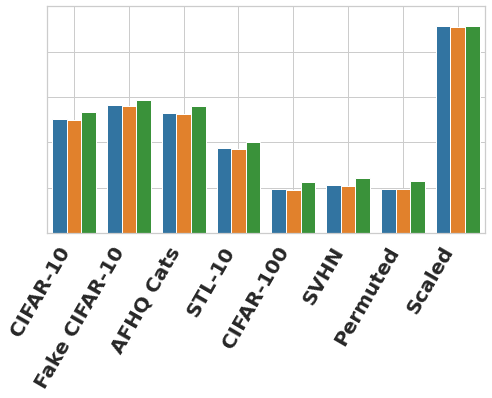

In [5]:
efficient_net_uncalibrated_df = get_cleaned_dataframe(
    '../results/efficient_net_cifar10_attack_results.csv',
    is_cifar10=True,
    rows_to_keep=rows_to_keep_cifar
)
efficient_net_uncalibrated_df = pd.melt(efficient_net_uncalibrated_df, id_vars=['Dataset'], var_name='Attack', value_name='FPR')
ax = plot_dataframe(efficient_net_uncalibrated_df)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('efficient_net_cifar10_attack_results_scores.pdf')

# ResNet-18

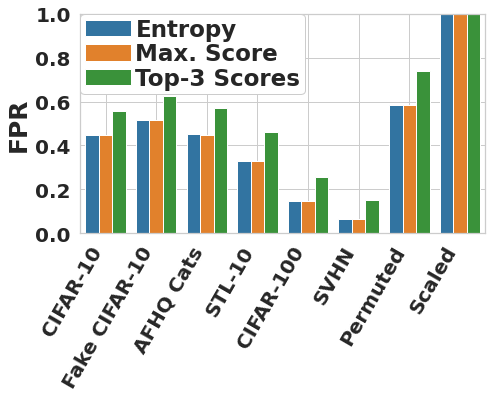

In [6]:
resnet18_uncalibrated_df = get_cleaned_dataframe(
    '../results/resnet18_cifar10_attack_results.csv',
    is_cifar10=True,
    rows_to_keep=rows_to_keep_cifar
)
resnet18_uncalibrated_df = pd.melt(resnet18_uncalibrated_df, id_vars=['Dataset'], var_name='Attack', value_name='FPR')
ax = plot_dataframe(resnet18_uncalibrated_df, show_y_label=True, show_y_axis=True, show_legend=True)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('resnet18_cifar10_attack_results_scores.pdf')

# ResNet-50

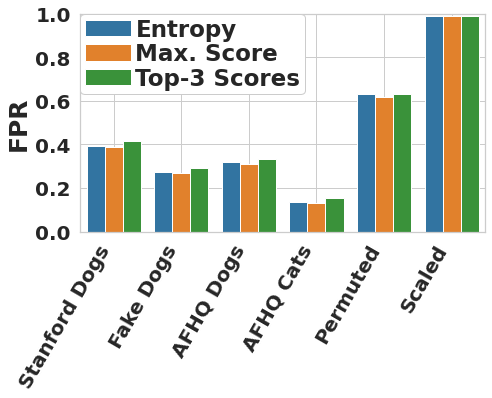

In [7]:
resnet50_uncalibrated_df = get_cleaned_dataframe(
    '../results/resnet50_stanford_dogs_attack_results.csv',
    is_cifar10=False,
    rows_to_keep=rows_to_keep_dogs
)

resnet50_uncalibrated_df = pd.melt(resnet50_uncalibrated_df, id_vars=['Dataset'], var_name='Attack', value_name='FPR')
ax = plot_dataframe(resnet50_uncalibrated_df, show_y_label=True, show_y_axis=True, show_legend=True)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('resnet50_attack_results.pdf')

# Example Images

In [8]:
SEED = 42
NUM_SAMPLES = 10000
ATTACK_SAMPLES = 2500
torch.manual_seed(SEED);

In [9]:
resnet18_target_model = resnet.ResNet18()
resnet18_shadow_model = resnet.ResNet18()
resnet18_target_model.load_state_dict(torch.load('../../experiments/pretrained_models/resnet18_cifar10_target.pt'))
resnet18_shadow_model.load_state_dict(torch.load('../../experiments/pretrained_models/resnet18_cifar10_shadow.pt'));

In [10]:
dataset_normalize = get_normalization('cifar10')
dataset_transform = T.Compose(
    [T.Resize((32, 32)), T.ToTensor(), dataset_normalize]
)
original_train_dataset = torchvision.datasets.CIFAR10(
            root='../data', train=True, download=True, transform=dataset_transform
        )
original_test_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=dataset_transform
)

# get the training dataset for the target/shadow model
subsampled_train_dataset = get_subsampled_dataset(
    original_train_dataset, 12500 * 2, seed=SEED, stratify=True
)
target_train, shadow_train = get_train_val_split(subsampled_train_dataset, 0.5, seed=SEED, stratify=True)
# get the test dataset for the target/shadow model
subsampled_test_dataset = original_test_dataset
if len(original_test_dataset) > 5000 * 2:
    subsampled_test_dataset = get_subsampled_dataset(
        original_test_dataset, 5000 * 2, seed=SEED, stratify=False
    )
target_test, shadow_test = get_train_val_split(subsampled_test_dataset, 0.5, seed=SEED, stratify=True)
print(f'Trainingset size: {len(subsampled_train_dataset)} - Testset size: {len(subsampled_test_dataset)}')
print(f'Trainingset size target: {len(target_train)} - Testset size target: {len(target_test)}')
print(f'Trainingset size shadow: {len(shadow_train)} - Testset size shadow: {len(shadow_test)}')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Trainingset size: 25000 - Testset size: 10000
Trainingset size target: 12500 - Testset size target: 5000
Trainingset size shadow: 12500 - Testset size shadow: 5000


In [11]:
def get_member_non_member_split(train_set, test_set, split_size):
    # get the member subset of the target training data that can be used for finding a threshold and attacking the model
    member = get_subsampled_dataset(train_set, split_size)
    # get the non-member subset of the target test data that can be used for finding a threshold and attacking the model
    non_member = get_subsampled_dataset(test_set, split_size)

    return member, non_member

# get the member and non-member for the target model
member_target, non_member_target = get_member_non_member_split(target_train, target_test, 2500)
print(f'Size Member Target: {len(member_target)} \t Size Non-Member Target: {len(non_member_target)}')
# get the member and non-member for the shadow model
member_shadow, non_member_shadow = get_member_non_member_split(shadow_train, shadow_test, 2500)
print(f'Size Member Shadow: {len(member_shadow)} \t Size Non-Member Shadow: {len(non_member_shadow)}')


Size Member Target: 2500 	 Size Non-Member Target: 2500
Size Member Shadow: 2500 	 Size Non-Member Shadow: 2500


In [12]:
print(
    f'ResNet-18 Target Model Training Acc={evaluate(resnet18_target_model, target_train):.4f} ' +
    f'\t ResNet-18 Target Model Test Acc={evaluate(resnet18_target_model, target_test):.4f}'
)
print(
    f'ResNet-18 Shadow Model Training Acc={evaluate(resnet18_shadow_model, shadow_train):.4f} ' +
    f'\t ResNet-18 Shadow Model Test Acc={evaluate(resnet18_shadow_model, shadow_test):.4f}'
)


ResNet-18 Target Model Training Acc=1.0000 	 ResNet-18 Target Model Test Acc=0.6992
ResNet-18 Shadow Model Training Acc=0.9965 	 ResNet-18 Shadow Model Test Acc=0.6832


In [13]:
# Load OOD data

# get the stl10 dataset and filter out all monkeys since there are no monkeys in the cifar10 dataset
stl10_to_cifar = {0: 0, 1: 2, 2: 1, 3: 3, 4: 4, 5: 5, 6: 7, 7: -1, 8: 8, 9: 9}

def target_transform_stl(idx):
    return stl10_to_cifar[idx]

stl10_ood_dataset = torchvision.datasets.STL10(
    root='../data',
    split='train',
    download=True,
    transform=dataset_transform,
    target_transform=target_transform_stl
)
stl10_ood_dataset = Subset(stl10_ood_dataset, np.where(stl10_ood_dataset.labels != 7)[0])
fake_cifar_ood_dataset = FakeCIFAR10(root='../data', train=True, transform=dataset_transform)
cifar100_ood_dataset = torchvision.datasets.CIFAR100(
    root='../data', train=True, download=True, transform=dataset_transform
)
svhn_ood_dataset = torchvision.datasets.SVHN(
    root='../data', split='train', download=True, transform=dataset_transform
)
stanford_dogs_ood_dataset = StanfordDogs(
    root='../data', train=True, download=True, transform=dataset_transform
)
afhq_ood_dataset = AFHQ(
    '../data', train=True, download=True, transform=dataset_transform
)
afhq_cats_ood_dataset = Subset(afhq_ood_dataset, np.where(np.array(afhq_ood_dataset.targets) == 0)[0])
afhq_dogs_ood_dataset = Subset(afhq_ood_dataset, np.where(np.array(afhq_ood_dataset.targets) == 1)[0])

# create the permuted dataset from the non-members
permuted_ood_dataset = create_permuted_dataset(non_member_target)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
attacks = [
    ThresholdAttack(apply_softmax=True),
    SalemAttack(apply_softmax=True, k=3),
    EntropyAttack(apply_softmax=True)
]
# learn the attack parameters for each attack
for attack in attacks:
    attack.learn_attack_parameters(resnet18_shadow_model, member_shadow, non_member_shadow)

In [ ]:
def find_fp(dataset, attacks, target_model, start_idx=0, class_idx=None):
    idx = start_idx
    while True:
        with torch.no_grad():
            image, label = dataset[idx]
            if class_idx is not None and label != class_idx:
                idx += 1
                continue

            fp_predictions = 0
            for attack in attacks:
                pred = attack.predict_membership(
                    target_model, TensorDataset(image.unsqueeze(0), torch.zeros(1)))
                if pred == 0:
                    break
                fp_predictions += pred
        if fp_predictions == 3:
            return image, idx
        idx += 1

In [ ]:
invert_transform = get_inverse_normalization('cifar10')

In [ ]:
x_cifar10, idx = find_fp(member_target, attacks, resnet18_target_model, start_idx=35)
print(idx)
plt.imshow(invert_transform(x_cifar10).permute(1, 2, 0))

In [ ]:
x_cifar10_test, idx = find_fp(non_member_target, attacks, resnet18_target_model, start_idx=0)
print(idx)
plt.imshow(invert_transform(x_cifar10_test).permute(1, 2, 0))

In [ ]:
x_fake_cifar, idx = find_fp(fake_cifar_ood_dataset, attacks, resnet18_target_model, start_idx=4043)
print(idx)
plt.imshow(invert_transform(x_fake_cifar).permute(1, 2, 0))

In [ ]:
x_stl10, idx = find_fp(stl10_ood_dataset, attacks, resnet18_target_model, start_idx=427, class_idx=2)
print(idx)
plt.imshow(invert_transform(x_stl10).permute(1, 2, 0))

In [ ]:
x_cifar100, idx = find_fp(cifar100_ood_dataset, attacks, resnet18_target_model, start_idx=2280, class_idx=92)
print(idx)
plt.imshow(invert_transform(x_cifar100).permute(1, 2, 0))

In [ ]:
x_cats, idx = find_fp(afhq_cats_ood_dataset, attacks, resnet18_target_model, start_idx=13)
print(idx)
plt.imshow(invert_transform(x_cats).permute(1, 2, 0))

In [ ]:
x_svhn, idx = find_fp(svhn_ood_dataset, attacks, resnet18_target_model, start_idx=0)
print(idx)
plt.imshow(invert_transform(x_svhn).permute(1, 2, 0))

In [ ]:
x_noise, idx = find_fp(permuted_ood_dataset, attacks, resnet18_target_model, start_idx=2)
print(idx)
plt.imshow(invert_transform(x_noise).permute(1, 2, 0))

In [ ]:
samples = [x_cifar10, x_cifar10_test, x_fake_cifar, x_stl10, x_cifar100, x_cats, x_svhn, x_noise]
titles = ['CIFAR-10 \n Training Set', 'CIFAR-10 \n Test Set',  'Fake CIFAR-10', 'STL-10', 'CIFAR-100',
          'AFHQ Cats', 'SVHN', 'Random Noise',]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, sample, title in zip(axs.flat, samples, titles):
    with torch.no_grad():
        conf = resnet18_target_model(sample.unsqueeze(0).cuda()).softmax(1)
        max_conf = conf.cpu().max().item()
    ax.imshow(invert_transform(sample).permute(1,2,0), aspect='equal')
    ax.annotate(f'{max_conf:.4f}', xy=(5, 1),
                xytext=(0.95, 0.05), textcoords='axes fraction',
                horizontalalignment='right', verticalalignment='bottom',
                color='black', backgroundcolor='white', fontsize=13)
    if title == 'CIFAR-10 \n Training Set':
        plt.setp(ax.spines.values(), color='lime', linewidth=5)
    else:
        plt.setp(ax.spines.values(), color='red', linewidth=5)
    ax.set_title(title, fontsize=17)

plt.tight_layout(h_pad=1, w_pad=1)
plt.show()
fig.savefig('false_positive_samples.pdf', dpi=300, bbox_inches='tight', pad_inches=0.05)
